# Assignment 3
### Author: Frank Schiro & Florian Mudekereza
### Course: CS 7420 Machine Learning
### Fall 2020

In [366]:
#---------- Packages -------------#
import numpy as np
import numpy.linalg as la
from sklearn import datasets
import ipywidgets as widgets
import matplotlib.pyplot as plt
from scipy import special
import math
import pandas as pd
np.random.seed(11)
digits = datasets.load_digits()
from sklearn.preprocessing import PolynomialFeatures as pf
#---------------------------------#

## Some Data Exploration

In [367]:
print(digits.data.shape)
print(digits.data.copy()[1, ])
#print(digits['DESCR'])

df = pd.DataFrame(digits.data)
print("Rows = ", len(df.index))
print("Cols = ", len(df.columns))
#print(df.head(3))

Y = pd.DataFrame(digits.target.copy())
print("Rows = ", len(Y.index))
print("Cols = ", len(Y.columns))
print(Y.head(3))


density = sum(digits.data.copy()[1, ]) / len(digits.data.copy()[1, ])
df = digits.data.copy()
X = np.matrix([
    # density
    df.sum(axis=1) /  len(df[1, ]),
    df.sum(axis=1) /  len(df[1, ]),
    df.sum(axis=1) /  len(df[1, ])
])
X = np.transpose(X)
print(X)



(1797, 64)
[ 0.  0.  0. 12. 13.  5.  0.  0.  0.  0.  0. 11. 16.  9.  0.  0.  0.  0.
  3. 15. 16.  6.  0.  0.  0.  7. 15. 16. 16.  2.  0.  0.  0.  0.  1. 16.
 16.  3.  0.  0.  0.  0.  1. 16. 16.  6.  0.  0.  0.  0.  1. 16. 16.  6.
  0.  0.  0.  0.  0. 11. 16. 10.  0.  0.]
Rows =  1797
Cols =  64
Rows =  1797
Cols =  1
   0
0  0
1  1
2  2
[[4.59375  4.59375  4.59375 ]
 [4.890625 4.890625 4.890625]
 [5.375    5.375    5.375   ]
 ...
 [5.84375  5.84375  5.84375 ]
 [5.375    5.375    5.375   ]
 [6.125    6.125    6.125   ]]


## PCA

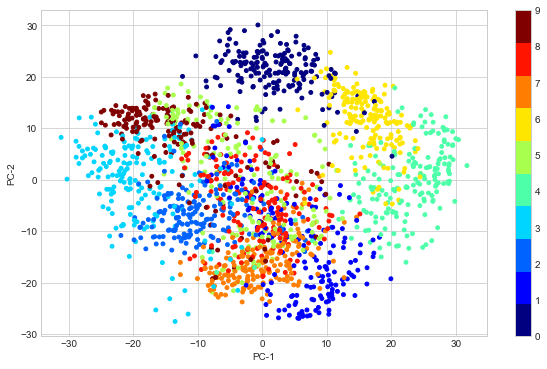

In [368]:
#Import required modules
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
 
digits = load_digits()
data = digits.data
data.shape
pca = PCA(2) # we need 2 principal components.
converted_data = pca.fit_transform(digits.data)
 
converted_data.shape

# quick vizualization of the transformed data
plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (10,6))
c_map = plt.cm.get_cmap('jet', 10)
plt.scatter(converted_data[:, 0], converted_data[:, 1], s = 15,
            cmap = c_map , c = digits.target)
plt.colorbar()
plt.xlabel('PC-1') , plt.ylabel('PC-2')
plt.savefig('pca.png')
plt.show()

## Logistic Regression Functions with Regularization

In [369]:
import warnings
# Minimize the logistic regression cost function given design matrix X,
# dependent variable Y, init cond beta(t=0)

def minimizeLogisticRegression(X, Y, beta, lambda0, numberVars):
    #print("Starting minimization: ")
    warnings.filterwarnings(yes)
    objOld = 10**9
    obj = 100
    output = []
    iterat = []
    iterations = 0
    while abs(objOld - obj) > 10**(-2) or np.isinf(obj):
        objOld = obj        
        Z = np.exp(np.multiply(-Y, np.matmul(X, beta)))
        np.put(Z, np.where(np.isinf(Z)), 10**9)
        n = X.shape[0] 
        Z2 = Z / (1 + Z)
        
        # Depreciated:
        #------------------------
        #gradE = np.array([
        #    np.matmul(Z2.transpose(), Y) + 2 * beta[0] * lambda0
        #])
        #for i in range(X.shape[1] - 1):
        #    gradE = np.append(gradE, np.matmul(Z2.transpose(), np.multiply(Y, X[:, (i+1)]))  + 2 * beta[(i+1)] * lambda0)
        #------------------------
        
        a = np.array([Y.reshape(len(Y), ), ] * X.shape[1]).transpose()
        b = np.multiply(X, a)
        gradE = - np.matmul(Z2.transpose(), b) + (beta.transpose() * lambda0)
        gradE = (1 / n) * gradE
        gradE = gradE.reshape(gradE.shape[1], ).transpose()
        #gradE = gradE.reshape(4,).transpose()
        G = - gradE / la.norm(gradE)
        # stop criteria
        # f(x + tdx) < f(x) + alpha * t * gradF * G
        Tmin = 0
        Tmax = 1
        alpha = .1
        obj = (1 / n) * (sum(np.log(1 + Z))) + 0.5* lambda0 * np.matmul(beta.transpose(), beta)
        G = G.reshape(numberVars, 1)
        beta = beta.reshape(numberVars, 1)
        while (Tmax - Tmin) > .00005:
            T = Tmin + (Tmax - Tmin) / 2
            betaTmp = beta + T * G
            Z = np.exp(np.multiply(-Y, np.matmul(X, betaTmp)))
            objTmp = 1 / n * (np.sum(np.log(1 + Z))) + 0.5 * lambda0 * np.matmul(beta.transpose(), beta)
            stopCrit = objTmp > obj + alpha * T * np.matmul(gradE.transpose(), G)
            if not stopCrit:
                # this T point not too large so keep all to right
                Tmin = T
            else:
                Tmax = T    
        beta = beta + T * G
        Z = np.exp(np.multiply(-Y, np.matmul(X, beta)))
        obj = 1 / n * (np.sum(np.log(1 + Z))) + 0.5 * lambda0 * np.matmul(beta.transpose(), beta)
        output.append(obj)
        iterations += 1
        iterat.append(iterations)
        if(iterations % 1000 == 0):
            pass 
            #print(iterations)
            #print("Objective = ", obj)
            #print("First few elements of beta: ", beta[0: min(4, (len(beta) - 1))])
    return [beta, output, iterat]


# Multiclass logistic regression 
# returns logistic regression coefficients for each class in Y
# for 3 class returns: 100, 010, 001
# where 0...0i0...0 is a logistic regression where class i is positive, all other class negative
#For i = 1:number of classes
# Set i = positive class
#    set not i = negative class
        #calculate coefficients beta for logistic regression


def multiClassLogReg(X, Y, beta0, lambda0,numberVars):
    classes = np.unique(Y)
    out = []
    # negative1 should not be a class of solution set for this to work
    for i in range(len(classes)):
        y = Y.copy()
        np.put(y, np.where(y != classes[i]), -1)
        np.put(y, np.where(y == classes[i]), 1)
        y = y.reshape(len(y), 1)
        out.append(minimizeLogisticRegression(X, y, beta0, lambda0,numberVars)[0])
    return(out)

#classifyMulticlassLogreg:

#Classifies each sample in a multiple-class logistic regression.
#Output = class which has the highest probability Input = array of array. Each sub-array is made of beta coefficients for each class

# input design matrix X, output of multiClassLogReg BETA
# output = classification of every row of logReg

def classifyMulticlassLogreg(X, BETA):
    out = []
    for beta in BETA:
        out.append(logReg(X, beta))
    return(np.argmax(out, 0))

# compute the probability x is in positive class given beta

def logReg(x, beta):
    z = np.exp(np.matmul(x, beta))
    # probability close to 1 returns infinity. 
    np.put(z, np.where(np.isinf(z)), 10^9)
    return(z / (1 + z))

#logRegClassify
#Classifies each sample for a single class logistic regression
# classify a single class logistic regression

def logRegClassify(X, beta):
    out = logReg(X, beta)
    np.put(out, np.where(out > .5), 1)
    np.put(out, np.where(out <= .5), 0)
    return(out)

## Create Design Matrix

In [370]:
def normGrad(i):
    # norm of gradient of matrix
    return(la.norm(np.gradient(i.reshape(8, 8))))

def xsym(i):
    # take dot products between symmetrix columns of matrix - entire matrix normalized to sum to 1.
    i = (i / i.sum()).reshape(8, 8)
    return(
        sum(np.array([
            np.dot(i[:, 3], i[:, 4]),
            np.dot(i[:, 2], i[:, 5]),
            np.dot(i[:, 1], i[:, 6]),
            np.dot(i[:, 0], i[:, 7])
        ]))
    )

df = digits.data.copy()
X = np.matrix([
    # density
    df.sum(axis=1) /  len(df[1, ]),
    # norm of gradient in x and gradient in y
    list(map(normGrad, df)),
    # normalized column dot product for symmetry measure
    list(map(xsym, df))
])
X = np.transpose(X)
X2 = X.copy()


## Transforming Data into Degree 20 Polynomial

In [371]:
# Feature transformation
from sklearn.preprocessing import PolynomialFeatures
pf(degree=2)
trans = pf(degree=2)
data = trans.fit_transform(X)
print(X.shape)
print(data.shape)

(1797, 3)
(1797, 10)


# 2 Cross-validation

For validation, we use the k-fold cross-validation method. 
More precisely, we use 5-fold cross-validation with stratification. 
In other words, we split the data 5 ways to train, test, and validate the model.

In [372]:
from sklearn.model_selection import KFold
X = X2.copy()
X = np.hstack((np.ones((len(X), 1)), X))
Y = digits.target.copy()+10

def crossval(X_train, X_test, Y_train, Y_test):
    #this is the cross-validation function
    
    X_train = np.hstack((np.ones((len(X_train),1)), X_train))
    X_test = np.hstack((np.ones((len(X_test),1)), X_test))  
    #X_test=np.transpose(np.append([[1]], X_test, axis=0))
    beta0 = np.random.rand(X_train.shape[1], 1)

    BETA = multiClassLogReg(X_train, Y_train, beta0, lambda0,4)
    correct = np.sum(Y_test == classifyMulticlassLogreg(X_test, BETA))
    incorrect = np.sum(Y_test != classifyMulticlassLogreg(X_test, BETA))
    
    return correct/(correct+incorrect)

In [373]:
from sklearn.model_selection import StratifiedKFold
def accuracylog(X, k=5):
    # this implements the cross-validation with 5 folds 
    kf = StratifiedKFold(n_splits=k, shuffle=True)
    scores = []
    
    for train_index, test_index in kf.split(X.data,X.target):
        X_train, X_test, Y_train, Y_test = X.data[train_index], X.data[test_index], \
                                            X.target[train_index], X.target[test_index]
        df = X_train
        X1 = np.matrix([
            # density
            df.sum(axis=1) /  len(df[1, ]),
            # norm of gradient in x and gradient in y
            list(map(normGrad, df)),
            # normalized column dot product for symmetry measure
            list(map(xsym, df))
        ])
        X1 = np.transpose(X1)
        X_train1 = X1.copy()

        df1 = X_test
        Xt = np.matrix([
            # density
            df.sum(axis=1) /  len(df1[1, ]),
            # norm of gradient in x and gradient in y
            list(map(normGrad, df1)),
            # normalized column dot product for symmetry measure
            list(map(xsym, df1))
        ])
        X_test1 = np.transpose(Xt)
        
        scores.append(crossval(X_train1, X_train1, Y_train, Y_test))
    return [np.mean(scores),scores] #[Y_train.shape] 

In [374]:
# set height of bar graphs
bars1 = accuracylog(digits)[1]

In [375]:
def bargraph(bars1):
    fig = plt.figure()
    folds = ['1', '2', '3', '4', '5']
    y_pos = np.arange(len(folds))
    plt.xlabel('Folds', fontweight='bold')
    #ax.bar(folds,bars1)
    plt.bar(folds, bars1, color=("navy", "purple", "orange", "green","red"), alpha=0.75)
    plt.xticks(y_pos, folds)

    # Create legend & Show graphic
    plt.savefig('prediction.png')
    plt.show()

### 2.1 Out-of-sample Predictions

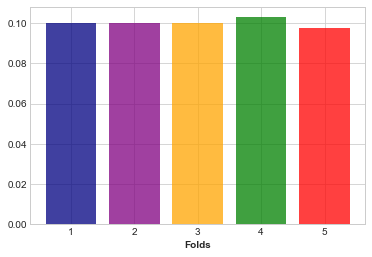

In [376]:
# Out-of-sample prediction bar graph
bargraph(bars1)

### 2.2 Performance Comparison with various lambda

In [377]:
from sklearn.model_selection import KFold
X = X2.copy()
X = np.hstack((np.ones((len(X), 1)), X))
Y = digits.target.copy()+10
beta0 = np.random.rand(X.shape[1], 1)
#minimizeLogisticRegression(X,Y,beta0,i,4)

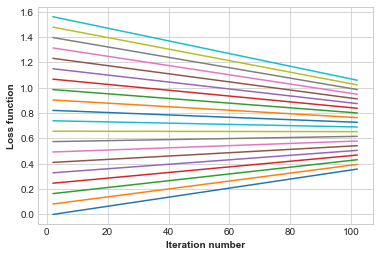

In [399]:
#for i in range(0,3):

def multiClassLogReg(X, Y, beta0, lambda0,numberVars):
    classes = np.unique(Y)
    o = []
    out = []
    t=[]
    t1=0
    # negative1 should not be a class of solution set for this to work
    for i in range(len(classes)):
        y = Y.copy()
        np.put(y, np.where(y != classes[i]), -1)
        np.put(y, np.where(y == classes[i]), 1)
        y = y.reshape(len(y), 1)
        out.append(np.mean(minimizeLogisticRegression(X, y, beta0, lambda0,numberVars)[1]))
        t.append(np.max(minimizeLogisticRegression(X, y, beta0, lambda0,numberVars)[2])+t1)
        t1+=100
    return(out,t)

for lambda1 in np.arange(0,2,0.1):
        out,t=multiClassLogReg(X, y, beta0, lambda1,4)
        plt.plot(t,out)
        
plt.ylabel('Loss function', fontweight='bold')
plt.xlabel('Iteration number', fontweight='bold')
plt.savefig('comparison.png')
plt.show()